In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
from tensorflow.keras import Model, losses, optimizers
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
from PIL import Image
%matplotlib inline

In [ ]:
import pandas as pd
import os
import glob
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loop through the file destination for all the csv files

# jpg
path_jpgA = '/content/drive/MyDrive/APM project/dataset1/trainA/*.jpg'
path_jpgB = '/content/drive/MyDrive/APM project/dataset1/trainB/*.jpg'
path_jpgA2 = '/content/drive/MyDrive/APM project/dataset1/testA/*.jpg'
path_jpgB2 = '/content/drive/MyDrive/APM project/dataset1/testB/*.jpg'

# jpeg
path_jpegA = '/content/drive/MyDrive/APM project/dataset1/trainA/*.jpeg'
path_jpegB = '/content/drive/MyDrive/APM project/dataset1/trainB/*.jpeg'
path_jpegA2 = '/content/drive/MyDrive/APM project/dataset1/testA/*.jpeg'
path_jpegB2 = '/content/drive/MyDrive/APM project/dataset1/testB/*.jpeg'

In [ ]:
trainA = glob.glob(path_jpgA) + glob.glob(path_jpegA)
trainB = glob.glob(path_jpgB) + glob.glob(path_jpegB)
testA = glob.glob(path_jpgA2) + glob.glob(path_jpegA2)
testB = glob.glob(path_jpgB2) + glob.glob(path_jpegB2)

In [ ]:
print(len(trainA))
print(len(trainB))
print(len(testA))
print(len(testB))

51
50
9
13


In [ ]:
path_trA = tf.data.Dataset.from_tensor_slices(trainA)
path_trB = tf.data.Dataset.from_tensor_slices(trainB)
path_teA = tf.data.Dataset.from_tensor_slices(testA)
path_teB = tf.data.Dataset.from_tensor_slices(testB)
AUTO = tf.data.experimental.AUTOTUNE

def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [256, 256])
  image /= 255.0  # normalize to [0,1] range
  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

def load_dataset(path):
  dataset = path.map(load_and_preprocess_image, num_parallel_calls=AUTO)
  return dataset


In [ ]:
def get_gan_dataset(old_files, new_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    old_ds = load_dataset(old_files)
    new_ds = load_dataset(new_files)

    if repeat:
        old_ds = old_ds.repeat()
        new_ds = new_ds.repeat()
    if shuffle:
        old_ds = old_ds.shuffle(2048)
        new_ds = new_ds.shuffle(2048)
        
    old_ds = old_ds.batch(batch_size, drop_remainder=True)
    new_ds = new_ds.batch(batch_size, drop_remainder=True)
    old_ds = old_ds.cache()
    new_ds = new_ds.cache()
    old_ds = old_ds.prefetch(AUTO)
    new_ds = new_ds.prefetch(AUTO)
    
    gan_ds = tf.data.Dataset.zip((old_ds, new_ds))
    return gan_ds

In [ ]:
def downsample(filters, size, apply_instancenorm=True, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(L.Conv2D(filters, size, strides=strides, padding='same',
                        kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(L.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(L.Conv2DTranspose(filters, size, strides=strides, padding='same',
                                 kernel_initializer=initializer, use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(L.Dropout(0.5))

    result.add(L.ReLU())

    return result

In [ ]:
OUTPUT_CHANNELS = 3

def generator_fn():
    inputs = L.Input(shape=[HEIGHT, WIDTH, CHANNELS])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4),                          # (bs, 64, 64, 128)
        downsample(256, 4),                          # (bs, 32, 32, 256)
        downsample(512, 4),                          # (bs, 16, 16, 512)
        downsample(512, 4),                          # (bs, 8, 8, 512)
        downsample(512, 4),                          # (bs, 4, 4, 512)
        downsample(512, 4),                          # (bs, 2, 2, 512)
        downsample(512, 4),                          # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4),                     # (bs, 16, 16, 1024)
        upsample(256, 4),                     # (bs, 32, 32, 512)
        upsample(128, 4),                     # (bs, 64, 64, 256)
        upsample(64, 4),                      # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = L.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                             strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = L.Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

In [ ]:
def discriminator_fn():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = L.Input(shape=[HEIGHT, WIDTH, CHANNELS], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = L.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = L.Conv2D(512, 4, strides=1,
                    kernel_initializer=initializer,
                    use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = L.LeakyReLU()(norm1)

    zero_pad2 = L.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = L.Conv2D(1, 4, strides=1,
                    kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return Model(inputs=inp, outputs=last)

In [ ]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
EPOCHS = 50
BATCH_SIZE = 1

In [ ]:
old_generator = generator_fn() # transforms photos to Monet-esque paintings
new_generator = generator_fn() # transforms Monet paintings to be more like photos

old_discriminator = discriminator_fn() # differentiates real Monet paintings and generated Monet paintings
new_discriminator = discriminator_fn() # differentiates real photos and generated photos


class CycleGan(Model):
  def __init__(
      self,
      old_generator,
      new_generator,
      old_discriminator,
      new_discriminator,
      lambda_cycle=10,
  ):
        super(CycleGan, self).__init__()
        self.o_gen = old_generator
        self.n_gen = new_generator
        self.o_disc = old_discriminator
        self.n_disc = new_discriminator
        self.lambda_cycle = lambda_cycle
      
  def compile(
      self,
      o_gen_optimizer,
      n_gen_optimizer,
      o_disc_optimizer,
      n_disc_optimizer,
      gen_loss_fn,
      disc_loss_fn,
      cycle_loss_fn,
      identity_loss_fn
  ):
        super(CycleGan, self).compile()
        self.o_gen_optimizer = o_gen_optimizer
        self.n_gen_optimizer = n_gen_optimizer
        self.o_disc_optimizer = o_disc_optimizer
        self.n_disc_optimizer = n_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
      
  def train_step(self, batch_data):
        real_old, real_new = batch_data
      
        with tf.GradientTape(persistent=True) as tape:
            # New to Old back to New
            fake_old = self.o_gen(real_new, training=True)
            cycled_new = self.n_gen(fake_old, training=True)

            # Old to New back to Old
            fake_new = self.n_gen(real_old, training=True)
            cycled_old = self.o_gen(fake_new, training=True)

            # generating itself
            same_old = self.o_gen(real_old, training=True)
            same_new = self.n_gen(real_new, training=True)

            # discriminator used to check, inputing real images
            disc_real_old = self.o_disc(real_old, training=True)
            disc_real_new = self.n_disc(real_new, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_old = self.o_disc(fake_old, training=True)
            disc_fake_new = self.n_disc(fake_new, training=True)

            # evaluates generator loss
            old_gen_loss = self.gen_loss_fn(disc_fake_old)
            new_gen_loss = self.gen_loss_fn(disc_fake_new)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_old, cycled_old, self.lambda_cycle) + self.cycle_loss_fn(real_new, cycled_new, self.lambda_cycle)

            # evaluates total generator loss
            total_old_gen_loss = old_gen_loss + total_cycle_loss + self.identity_loss_fn(real_old, same_old, self.lambda_cycle)
            total_new_gen_loss = new_gen_loss + total_cycle_loss + self.identity_loss_fn(real_new, same_new, self.lambda_cycle)

            # evaluates discriminator loss
            old_disc_loss = self.disc_loss_fn(disc_real_old, disc_fake_old)
            new_disc_loss = self.disc_loss_fn(disc_real_new, disc_fake_new)

        # Calculate the gradients for generator and discriminator
        old_generator_gradients = tape.gradient(total_old_gen_loss,
                                                  self.o_gen.trainable_variables)
        new_generator_gradients = tape.gradient(total_new_gen_loss,
                                                  self.n_gen.trainable_variables)

        old_discriminator_gradients = tape.gradient(old_disc_loss,
                                                      self.o_disc.trainable_variables)
        new_discriminator_gradients = tape.gradient(new_disc_loss,
                                                      self.n_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.o_gen_optimizer.apply_gradients(zip(old_generator_gradients,
                                                  self.o_gen.trainable_variables))

        self.n_gen_optimizer.apply_gradients(zip(new_generator_gradients,
                                                  self.n_gen.trainable_variables))

        self.o_disc_optimizer.apply_gradients(zip(old_discriminator_gradients,
                                                  self.o_disc.trainable_variables))

        self.n_disc_optimizer.apply_gradients(zip(new_discriminator_gradients,
                                                  self.n_disc.trainable_variables))
        
        return {
            'old_gen_loss': total_old_gen_loss,
            'new_gen_loss': total_new_gen_loss,
            'old_disc_loss': old_disc_loss,
            'new_disc_loss': new_disc_loss
        }

In [ ]:
    # Discriminator loss {0: fake, 1: real} (The discriminator loss outputs the average of the real and generated loss)
def discriminator_loss(real, generated):
  real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

  generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5
    
    # Generator loss
def generator_loss(generated):
  return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)


    # Cycle consistency loss (measures if original photo and the twice transformed photo to be similar to one another)
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

    # Identity loss (compares the image with its generator (i.e. photo with photo generator))
def identity_loss(real_image, same_image, LAMBDA):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
# Create generators
old_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
new_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

# Create discriminators
old_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
new_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

# Create GAN
gan_model = CycleGan(old_generator, new_generator, 
                      old_discriminator, new_discriminator)

gan_model.compile(o_gen_optimizer=old_generator_optimizer,
                  n_gen_optimizer=new_generator_optimizer,
                  o_disc_optimizer=old_discriminator_optimizer,
                  n_disc_optimizer=new_discriminator_optimizer,
                  gen_loss_fn=generator_loss,
                  disc_loss_fn=discriminator_loss,
                  cycle_loss_fn=calc_cycle_loss,
                  identity_loss_fn=identity_loss)

In [ ]:
n_old_samples = len(trainB)
n_old_samples

50

In [ ]:
history = gan_model.fit(get_gan_dataset(path_trB, path_trA, batch_size=BATCH_SIZE), 
                    steps_per_epoch=(n_old_samples//BATCH_SIZE),
                    epochs=EPOCHS,
                    verbose=2).history

Epoch 1/50
50/50 - 423s - old_gen_loss: 4.2610 - new_gen_loss: 3.9274 - old_disc_loss: 0.5606 - new_disc_loss: 0.6816
Epoch 2/50
50/50 - 422s - old_gen_loss: 3.8354 - new_gen_loss: 3.0370 - old_disc_loss: 0.3557 - new_disc_loss: 0.6652
Epoch 3/50
50/50 - 419s - old_gen_loss: 3.6046 - new_gen_loss: 2.7547 - old_disc_loss: 0.3127 - new_disc_loss: 0.6518
Epoch 4/50
50/50 - 420s - old_gen_loss: 4.1224 - new_gen_loss: 3.5144 - old_disc_loss: 0.7986 - new_disc_loss: 0.4445
Epoch 5/50
50/50 - 421s - old_gen_loss: 3.8866 - new_gen_loss: 3.6235 - old_disc_loss: 0.4127 - new_disc_loss: 0.3967
Epoch 6/50
50/50 - 422s - old_gen_loss: 2.9237 - new_gen_loss: 2.7574 - old_disc_loss: 0.6321 - new_disc_loss: 0.4763
Epoch 7/50
50/50 - 421s - old_gen_loss: 4.4844 - new_gen_loss: 3.4620 - old_disc_loss: 0.4451 - new_disc_loss: 0.6058
Epoch 8/50
50/50 - 420s - old_gen_loss: 3.6329 - new_gen_loss: 4.0529 - old_disc_loss: 0.5972 - new_disc_loss: 1.1283
Epoch 9/50
50/50 - 420s - old_gen_loss: 3.6706 - new_gen

In [ ]:
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        
        plt.subplot(121)
        plt.title("input image")
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

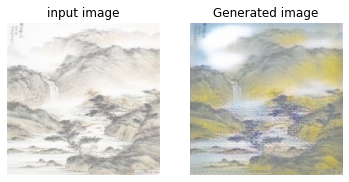

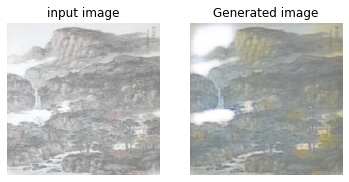

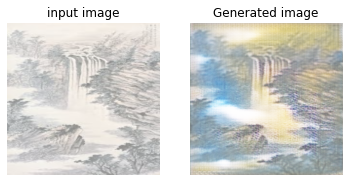

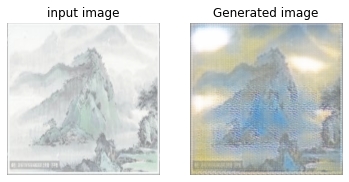

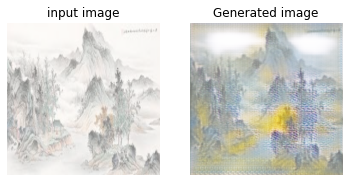

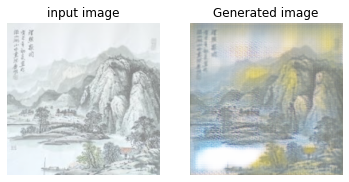

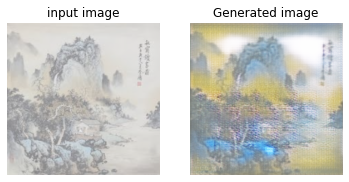

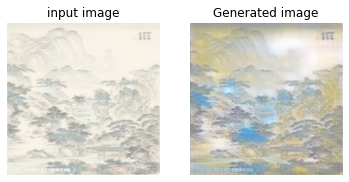

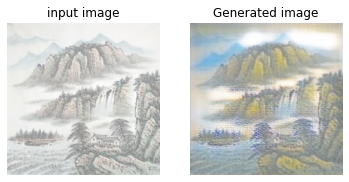

In [ ]:
display_generated_samples(load_dataset(path_teA).batch(1), old_generator, len(testA))

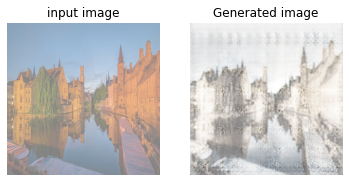

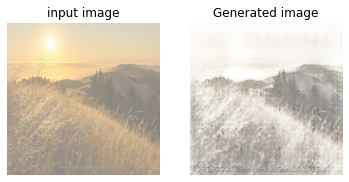

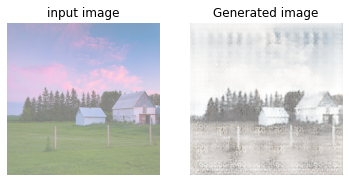

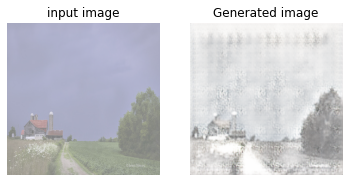

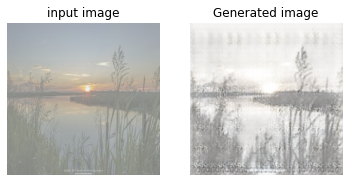

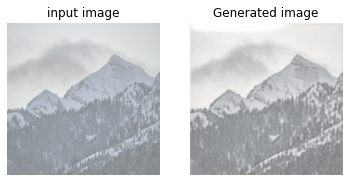

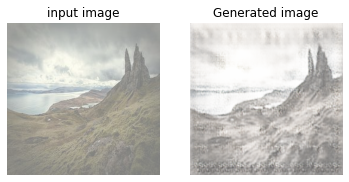

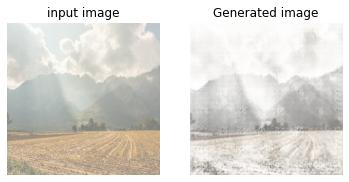

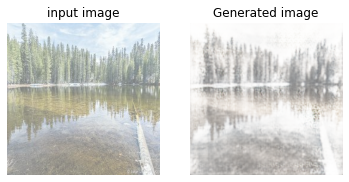

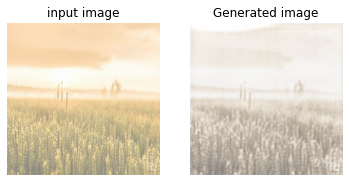

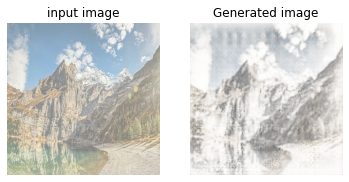

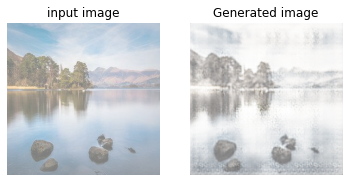

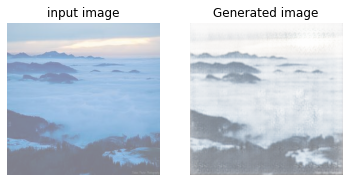

In [ ]:
display_generated_samples(load_dataset(path_teB).batch(1), new_generator, len(testB))